# Imports

In [1142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

from sklearn.linear_model import (
    LinearRegression,
)  # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import (
    LogisticRegression,
)  #  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn import tree  # https://scikit-learn.org/stable/modules/tree.html#regression
from sklearn.tree import (
    DecisionTreeClassifier,
)  # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.ensemble import (
    RandomForestRegressor,
)  # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import (
    RandomForestClassifier,
)  # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.metrics import f1_score

import lightgbm  # https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMModel.html#lightgbm.LGBMModel
from imblearn.over_sampling import SMOTE

# Read data

In [1143]:
df1 = pd.read_csv("./data/GPP_NEE_flux_2001-2022.csv")
df2 = pd.read_csv("./data/voc_2010-2022.csv")
df3 = pd.read_csv("./data/latent_heat_flux_2018-2022.csv")
df4 = pd.read_csv("./data/latent_heat_flux_2001-2018.csv")
df5 = pd.read_csv("./data/sensible_heat_flux_2001-2022.csv")
df6 = pd.read_csv("./data/HYY_META.PAR_1997-01-01--9999-09-09.csv")
df7 = pd.read_csv("./data/HYY_META.Precipacc_2005-04-01--9999-09-09.csv")
df8 = pd.read_csv("./data/HYY_META.T672_1997-01-01--9999-09-09.csv")
df9 = pd.read_csv("./data/HYY_META.wpsoil_A_2005-06-17--9999-09-09.csv")
df10 = pd.read_csv("./data/HYY_META.wsoil_B1_p50_2007-02-01--2023-04-04.csv")

# Drop columnns 'Unnamed: 0'
df1 = df1.drop(columns=["Unnamed: 0"])
df2 = df2.drop(columns=["Unnamed: 0"])
df3 = df3.drop(columns=["Unnamed: 0"])
df4 = df4.drop(columns=["Unnamed: 0"])
df5 = df5.drop(columns=["Unnamed: 0"])
df6 = df6.drop(columns=["Unnamed: 0"])
df7 = df7.drop(columns=["Unnamed: 0"])
df8 = df8.drop(columns=["Unnamed: 0"])
df9 = df9.drop(columns=["Unnamed: 0"])
df10 = df10.drop(columns=["Unnamed: 0"])

# Convert time labels to datetime objects
df1["Datetime"] = pd.to_datetime(df1["Datetime"])
df2["Datetime"] = pd.to_datetime(df2["Datetime"])
df3["Datetime"] = pd.to_datetime(df3["Datetime"])
df4["Datetime"] = pd.to_datetime(df4["Datetime"])
df5["Datetime"] = pd.to_datetime(df5["Datetime"])
df6["Datetime"] = pd.to_datetime(df6["Datetime"])
df7["Datetime"] = pd.to_datetime(df7["Datetime"])
df8["Datetime"] = pd.to_datetime(df8["Datetime"])
df9["Datetime"] = pd.to_datetime(df9["Datetime"])
df10["Datetime"] = pd.to_datetime(df10["Datetime"])

# Config parameters

## Time period

In [1144]:
# 1) Select start time of the analysis
START_TIME = pd.to_datetime("2010-06-01")

# 2) Select the months of interest
START_MONTH = 1
END_MONTH = 12

# 3) Select the measurement hours to consider. Allowed values are 'all', 'noon'
DAILY_HOURS = "noon"
# DAILY_HOURS = 'all'
assert DAILY_HOURS in ["all", "noon"]

## Aggregation

In [1145]:
# 1) Select the method for aggregating raw measurements to daily values. Allowed values are 'mean' or 'median'
# DAILY_AGG_METHOD = 'median'
DAILY_AGG_METHOD = "median"
assert DAILY_AGG_METHOD in ["mean", "median"]

# 2) Set the window size and aggregation method for combining daily measurements
WINDOW_SIZE = 3
# WINDOW_AGG_METHOD = 'median'
WINDOW_AGG_METHOD = "mean"
assert WINDOW_AGG_METHOD in ["mean", "median"]

# window size for the moving average and standard deviation
STATS_WINDOW_SIZE = 20

## Other parameters

In [1235]:
# Select target variables to use. Options are:
possible_target_variables = ["monoterp", "sensible_heat", "latent_heat", "nee"]

TARGET_VARIABLES = ["monoterp", "sensible_heat", "latent_heat", "nee"]
for x in TARGET_VARIABLES:
    assert x in possible_target_variables

dropped_target_variables = list(set(possible_target_variables) - set(TARGET_VARIABLES))

# Select stress stresholds to be used in classification
combined_stress_threshold = 3.5
individual_stress_threshold = 2

# Select whether to impute or delete missing values
impute = False

# Class weights for the tree based classifiers
class_weights = {0: 0.9, 1: 1.15}

# Max depth for the tree based classifiers
max_depth = 4

# Prepare the data

In [1147]:
if DAILY_HOURS == "noon":
    # keep only observations occurring during 10.00-14.00 each day
    df1 = df1[(df1["Datetime"].dt.hour >= 10) & (df1["Datetime"].dt.hour <= 14)]
    df2 = df2[(df2["Datetime"].dt.hour >= 10) & (df2["Datetime"].dt.hour <= 14)]
    df3 = df3[(df3["Datetime"].dt.hour >= 10) & (df3["Datetime"].dt.hour <= 14)]
    df4 = df4[(df4["Datetime"].dt.hour >= 10) & (df4["Datetime"].dt.hour <= 14)]
    df5 = df5[(df5["Datetime"].dt.hour >= 10) & (df5["Datetime"].dt.hour <= 14)]
    df6 = df6[(df6["Datetime"].dt.hour >= 10) & (df6["Datetime"].dt.hour <= 14)]
    df7 = df7[(df7["Datetime"].dt.hour >= 10) & (df7["Datetime"].dt.hour <= 14)]
    df8 = df8[(df8["Datetime"].dt.hour >= 10) & (df8["Datetime"].dt.hour <= 14)]
    df9 = df9[(df9["Datetime"].dt.hour >= 10) & (df9["Datetime"].dt.hour <= 14)]
    df10 = df10[(df10["Datetime"].dt.hour >= 10) & (df10["Datetime"].dt.hour <= 14)]

In [1148]:
# Keep only the rows where NEE_gapfilling_method is 0
df1 = df1[df1.NEE_gapfilling_method == 0]

# Reset the index
df1.reset_index(drop=True, inplace=True)

In [1149]:
# Aggregate to daily values
if DAILY_AGG_METHOD == "mean":
    daily_df1 = df1.resample("D", on="Datetime").mean().reset_index()
    daily_df2 = df2.resample("D", on="Datetime").mean().reset_index()
    daily_df3 = df3.resample("D", on="Datetime").mean().reset_index()
    daily_df4 = df4.resample("D", on="Datetime").mean().reset_index()
    daily_df5 = df5.resample("D", on="Datetime").mean().reset_index()
    daily_df6 = df6.resample("D", on="Datetime").mean().reset_index()
    daily_df7 = df7.resample("D", on="Datetime").mean().reset_index()
    daily_df8 = df8.resample("D", on="Datetime").mean().reset_index()
    daily_df9 = df9.resample("D", on="Datetime").mean().reset_index()
    daily_df10 = df10.resample("D", on="Datetime").mean().reset_index()
elif DAILY_AGG_METHOD == "median":
    daily_df1 = df1.resample("D", on="Datetime").median().reset_index()
    daily_df2 = df2.resample("D", on="Datetime").median().reset_index()
    daily_df3 = df3.resample("D", on="Datetime").median().reset_index()
    daily_df4 = df4.resample("D", on="Datetime").median().reset_index()
    daily_df5 = df5.resample("D", on="Datetime").median().reset_index()
    daily_df6 = df6.resample("D", on="Datetime").median().reset_index()
    daily_df7 = df7.resample("D", on="Datetime").median().reset_index()
    daily_df8 = df8.resample("D", on="Datetime").median().reset_index()
    daily_df9 = df9.resample("D", on="Datetime").median().reset_index()
    daily_df10 = df10.resample("D", on="Datetime").median().reset_index()
else:
    raise ValueError('agg_method must be either "mean" or "median"')

In [1150]:
# Combine latent heat flux data from 2001-2018 and 2018-2022 to same dataframe: lh_df
daily_df4 = daily_df4.rename(columns={"HYY_EDDY233.LE": "lh_flux"})
daily_df4 = daily_df4.drop(columns=["HYY_EDDY233.Qc_LE"])

daily_df3 = daily_df3.rename(columns={"latent_heat_flux_after_4-2018": "lh_flux"})
daily_df3 = daily_df3.drop(columns=["latent_heat_flux_quality_flag_after_4-2018"])
lh_df = pd.concat([daily_df4, daily_df3], ignore_index=True)

In [1151]:
# Drop unnecessary columns
daily_df1 = daily_df1.drop(columns=["NEE_gapfilling_method", "GPP"])
daily_df5 = daily_df5.drop(columns=["sensible_heat_flux_gapfilling_method"])
daily_df2 = daily_df2.drop(
    columns=["methanol_flux", "acetone_flux", "acetaldehyde_flux"]
)

In [1152]:
# Merge all variables into one dataframe
ddf = pd.merge(daily_df1, daily_df2, on="Datetime", how="outer")
ddf = pd.merge(ddf, lh_df, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df5, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df6, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df7, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df8, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df9, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df10, on="Datetime", how="outer")

In [1153]:
# Keep only the measurements after start_time
ddf = ddf[ddf["Datetime"] >= START_TIME]

# Filter data between start_month and end_month
ddf = ddf[
    (ddf["Datetime"].dt.month >= START_MONTH) & (ddf["Datetime"].dt.month <= END_MONTH)
]  # .copy()

In [1154]:
# Convert each daily value into a rolling value over the selected window size
if WINDOW_AGG_METHOD == "median":
    ddf["monoterp_rm"] = (
        ddf["monoterpene_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["sensible_heat_rm"] = (
        ddf["sensible_heat_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["latent_heat_rm"] = (
        ddf["lh_flux"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).median()
    )
    ddf["nee_rm"] = (
        ddf["NEE"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).median()
    )
    ddf["PAR_rm"] = (
        ddf["HYY_META.PAR"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["precip_rm"] = (
        ddf["HYY_META.Precipacc"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["t672_rm"] = (
        ddf["HYY_META.T672"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["wpsoil_A_rm"] = (
        ddf["HYY_META.wpsoil_A"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["wsoil_B1_p50_rm"] = (
        ddf["HYY_META.wsoil_B1_p50"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
elif WINDOW_AGG_METHOD == "mean":
    ddf["monoterp_rm"] = (
        ddf["monoterpene_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["sensible_heat_rm"] = (
        ddf["sensible_heat_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["latent_heat_rm"] = (
        ddf["lh_flux"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).mean()
    )
    ddf["nee_rm"] = (
        ddf["NEE"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).mean()
    )
    ddf["PAR_rm"] = (
        ddf["HYY_META.PAR"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["precip_rm"] = (
        ddf["HYY_META.Precipacc"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["t672_rm"] = (
        ddf["HYY_META.T672"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["wpsoil_A_rm"] = (
        ddf["HYY_META.wpsoil_A"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["wsoil_B1_p50_rm"] = (
        ddf["HYY_META.wsoil_B1_p50"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )

In [1155]:
# Add a column for the day of year
ddf["day"] = ddf["Datetime"].dt.dayofyear

# Add a column for the year
ddf["year"] = ddf["Datetime"].dt.year

In [1156]:
ddf.drop(
    columns=[
        "NEE",
        "monoterpene_flux",
        "lh_flux",
        "sensible_heat_flux",
        "HYY_META.PAR",
        "HYY_META.Precipacc",
        "HYY_META.T672",
        "HYY_META.wpsoil_A",
        "HYY_META.wsoil_B1_p50",
    ],
    inplace=True,
)

# Calculate z-scores

In [1157]:
# Pivot the DataFrame so that rows are days and columns are years
df_mono = ddf.pivot(index="day", columns="year", values="monoterp_rm")
df_sensible = ddf.pivot(index="day", columns="year", values="sensible_heat_rm")
df_latent = ddf.pivot(index="day", columns="year", values="latent_heat_rm")
df_nee = ddf.pivot(index="day", columns="year", values="nee_rm")
df_PAR = ddf.pivot(index="day", columns="year", values="PAR_rm")
df_precip = ddf.pivot(index="day", columns="year", values="precip_rm")
df_t672 = ddf.pivot(index="day", columns="year", values="t672_rm")
df_wpsoil_A = ddf.pivot(index="day", columns="year", values="wpsoil_A_rm")
df_wsoil_B1_p50 = ddf.pivot(index="day", columns="year", values="wsoil_B1_p50_rm")

# Drop column year from ddf
ddf.drop(columns=["year"], inplace=True)

In [1158]:
def rolling_stats(df, window_size):
    df["rolling_mean"] = np.nan
    df["rolling_std"] = np.nan

    for i in range(1, len(df) + 1):
        start = max(i - window_size//2, 0)
        stop = min(i + window_size//2, len(df))
        values = df.iloc[start:stop, :].values.flatten().tolist()
        filtered = [x for x in values if not math.isnan(x)]
        filtered = np.array(filtered)
        df.loc[i, "rolling_std"] = filtered.std(ddof=1)
        df.loc[i, "rolling_mean"] = filtered.mean()
        if impute:
            # Replace NaN values with the rolling mean for each row
            df.loc[i, :] = df.loc[i, :].fillna(df.loc[i, "rolling_mean"])

    return df

In [1159]:
df_mono = rolling_stats(df_mono, STATS_WINDOW_SIZE)
df_sensible = rolling_stats(df_sensible, STATS_WINDOW_SIZE)
df_latent = rolling_stats(df_latent, STATS_WINDOW_SIZE)
df_nee = rolling_stats(df_nee, STATS_WINDOW_SIZE)
df_PAR = rolling_stats(df_PAR, STATS_WINDOW_SIZE)
df_precip = rolling_stats(df_precip, STATS_WINDOW_SIZE)
df_t672 = rolling_stats(df_t672, STATS_WINDOW_SIZE)
df_wpsoil_A = rolling_stats(df_wpsoil_A, STATS_WINDOW_SIZE)
df_wsoil_B1_p50 = rolling_stats(df_wsoil_B1_p50, WINDOW_SIZE)

In [1160]:
df_mono

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,rolling_mean,rolling_std
day,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.439750,NaN,NaN,NaN,9.733200,NaN,44.5539,15.848851,30.524316
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.821000,NaN,NaN,NaN,-3.255400,NaN,NaN,14.137078,29.410174
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.291800,NaN,NaN,NaN,-17.217350,NaN,NaN,12.563671,28.061534
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.806545,40.36650,NaN,NaN,-10.571567,NaN,NaN,10.869115,27.655308
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.424830,128.54925,NaN,NaN,1.366667,NaN,NaN,10.793985,26.298616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,NaN,NaN,NaN,12.363353,NaN,NaN,-3.023460,NaN,NaN,NaN,-0.765550,NaN,-6.709600,NaN,5.595585,14.513307
363,NaN,NaN,NaN,11.641837,NaN,NaN,2.779857,NaN,NaN,NaN,3.826833,NaN,1.005067,NaN,6.012828,14.794282
364,NaN,NaN,NaN,12.559175,NaN,NaN,12.569823,NaN,NaN,NaN,-14.840000,NaN,8.693617,NaN,6.166356,15.252693


In [1161]:
df_precip

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,rolling_mean,rolling_std
day,,,,,,,,,,,,,,,,
1,NaN,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.003333,0.0,0.0,0.0,0.0,0.000210,0.000812
2,NaN,0.0,0.0,0.000000,0.0,0.003333,0.0,0.0,0.0,0.003333,0.0,0.0,0.0,0.0,0.000281,0.000993
3,NaN,0.0,0.0,0.000000,0.0,0.003333,0.0,0.0,0.0,0.003333,0.0,0.0,0.0,0.0,0.000370,0.001145
4,NaN,0.0,0.0,0.000000,0.0,0.003333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000428,0.001235
5,NaN,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000479,0.001263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.0,0.0,0.0,0.003333,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000357,0.000958
363,0.0,0.0,0.0,0.003333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000347,0.000940
364,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000337,0.000918


In [1162]:
z_scores

,Datetime,day,monoterp_zscore,sensible_heat_zscore,latent_heat_zscore,nee_zscore,PAR_zscore,precip_zscore,t672_zscore,wpsoil_A_zscore,wsoil_B1_p50_zscore
0,2010-06-01,152,-0.875638,1.482582,1.322902,-0.209937,1.381768,-0.288873,0.238080,0.714971,1.263175
1,2010-06-02,153,-0.894983,1.800797,1.382352,-0.099383,1.424750,-0.270698,0.561291,0.624250,1.226054
2,2010-06-03,154,-0.885570,1.641824,1.331908,-0.215089,1.403161,-0.270025,0.627500,0.554736,1.158473
3,2010-06-04,155,NaN,1.527501,1.071969,-0.569055,0.788548,-0.279792,0.309383,0.503225,1.077868
4,2010-06-05,156,NaN,0.947868,0.629469,-0.905905,-0.028468,-0.285550,-0.437374,0.468133,1.065370
...,...,...,...,...,...,...,...,...,...,...,...
4957,2023-12-27,361,NaN,NaN,NaN,NaN,0.461354,-0.374234,-0.505059,0.338725,NaN
4958,2023-12-28,362,NaN,NaN,NaN,NaN,0.796891,-0.373018,-0.472990,0.340892,NaN
4959,2023-12-29,363,NaN,NaN,NaN,NaN,-0.072777,-0.371648,-0.338511,0.343277,NaN
4960,2023-12-30,364,NaN,NaN,NaN,NaN,-0.295205,-0.369126,-0.480452,0.345448,NaN


In [1163]:
# Create a new dataframe for z-scores as a copy of ddf
z_scores = ddf.copy()
z_scores.set_index("Datetime", inplace=True)

# calculate z-scores for each variable
for index, row in z_scores.iterrows():
    day = index.dayofyear

    z_scores.at[index, "monoterp_zscore"] = (
        row["monoterp_rm"] - df_mono.loc[day,"rolling_mean"]
    ) / df_mono.loc[day, "rolling_std"]

    z_scores.at[index, "sensible_heat_zscore"] = (
        row["sensible_heat_rm"] - df_sensible.loc[day, "rolling_mean"]
    ) / df_sensible.loc[day, "rolling_std"]

    z_scores.at[index, "latent_heat_zscore"] = (
        row["latent_heat_rm"] - df_latent.loc[day, "rolling_mean"]
    ) / df_latent.loc[day, "rolling_std"]

    z_scores.at[index, "nee_zscore"] = (
        row["nee_rm"] - df_nee.loc[day, "rolling_mean"]
    ) / df_nee.loc[day, "rolling_std"]

    z_scores.at[index, "PAR_zscore"] = (
        row["PAR_rm"] - df_PAR.loc[day, "rolling_mean"]
    ) / df_PAR.loc[day, "rolling_std"]

    z_scores.at[index, "precip_zscore"] = (
        row["precip_rm"] - df_precip.loc[day, "rolling_mean"]
    ) / df_precip.loc[day, "rolling_std"]

    z_scores.at[index, "t672_zscore"] = (
        row["t672_rm"] - df_t672.loc[day, "rolling_mean"]
    ) / df_t672.loc[day, "rolling_std"]

    z_scores.at[index, "wpsoil_A_zscore"] = (
        row["wpsoil_A_rm"] - df_wpsoil_A.loc[day, "rolling_mean"]
    ) / df_wpsoil_A.loc[day, "rolling_std"]

    z_scores.at[index, "wsoil_B1_p50_zscore"] = (
        row["wsoil_B1_p50_rm"] - df_wsoil_B1_p50.loc[day, "rolling_mean"]
    ) / df_wsoil_B1_p50.loc[day, "rolling_std"]


z_scores.drop(
    columns=[
        "monoterp_rm",
        "sensible_heat_rm",
        "latent_heat_rm",
        "nee_rm",
        "PAR_rm",
        "precip_rm",
        "t672_rm",
        "wpsoil_A_rm",
        "wsoil_B1_p50_rm",
    ],
    inplace=True,
)

z_scores_2010 = z_scores[z_scores.index.year == 2010]
z_scores_2011 = z_scores[z_scores.index.year == 2011]
z_scores_2012 = z_scores[z_scores.index.year == 2012]
z_scores_2013 = z_scores[z_scores.index.year == 2013]
z_scores_2014 = z_scores[z_scores.index.year == 2014]
z_scores_2015 = z_scores[z_scores.index.year == 2015]
z_scores_2016 = z_scores[z_scores.index.year == 2016]
z_scores_2017 = z_scores[z_scores.index.year == 2017]
z_scores_2018 = z_scores[z_scores.index.year == 2018]
z_scores_2019 = z_scores[z_scores.index.year == 2019]
z_scores_2020 = z_scores[z_scores.index.year == 2020]
z_scores_2021 = z_scores[z_scores.index.year == 2021]
z_scores_2022 = z_scores[z_scores.index.year == 2022]

z_scores_2010.set_index("day", inplace=True)
z_scores_2011.set_index("day", inplace=True)
z_scores_2012.set_index("day", inplace=True)
z_scores_2013.set_index("day", inplace=True)
z_scores_2014.set_index("day", inplace=True)
z_scores_2015.set_index("day", inplace=True)
z_scores_2016.set_index("day", inplace=True)
z_scores_2017.set_index("day", inplace=True)
z_scores_2018.set_index("day", inplace=True)
z_scores_2019.set_index("day", inplace=True)
z_scores_2020.set_index("day", inplace=True)
z_scores_2021.set_index("day", inplace=True)
z_scores_2022.set_index("day", inplace=True)

In [1164]:
display(z_scores_2011.head(15))

,monoterp_zscore,sensible_heat_zscore,latent_heat_zscore,nee_zscore,PAR_zscore,precip_zscore,t672_zscore,wpsoil_A_zscore,wsoil_B1_p50_zscore
day,,,,,,,,,
1,NaN,0.415322,NaN,NaN,-0.826491,-0.258253,-1.023270,-0.622995,-2.540817
2,NaN,0.368921,NaN,NaN,-0.217468,-0.282610,-0.886189,-0.505853,-2.531783
3,NaN,0.027625,NaN,NaN,0.064866,-0.323016,-1.022876,-0.418451,-2.502603
4,NaN,-0.188916,NaN,NaN,0.324200,-0.346484,-1.411213,-0.478464,-2.471489
5,NaN,-0.482642,NaN,NaN,0.350550,-0.378818,-1.470495,-0.683014,-2.470568
6,NaN,-0.347613,NaN,NaN,-0.233345,-0.393506,-1.224867,-0.857045,-2.453169
7,NaN,-0.271782,NaN,NaN,-0.807051,-0.406375,-0.738229,-0.872888,-2.388712
8,NaN,0.051326,-0.892855,0.099793,-0.971202,-0.404453,-0.410419,-0.665759,-2.138448
9,NaN,0.430008,-0.958449,-0.134315,-1.072064,-0.396375,0.091799,-0.398875,-1.780818


In [1165]:
z_scores

,day,monoterp_zscore,sensible_heat_zscore,latent_heat_zscore,nee_zscore,PAR_zscore,precip_zscore,t672_zscore,wpsoil_A_zscore,wsoil_B1_p50_zscore
Datetime,,,,,,,,,,
2010-06-01,152,-0.808205,1.437598,1.267525,-0.190391,1.359425,-0.279940,0.219242,0.707948,1.263175
2010-06-02,153,-0.817351,1.750855,1.329212,-0.084918,1.404968,-0.264424,0.535717,0.619610,1.226054
2010-06-03,154,-0.794248,1.601499,1.283795,-0.198568,1.386983,-0.265804,0.603030,0.551731,1.158473
2010-06-04,155,NaN,1.495137,1.033571,-0.543821,0.781193,-0.277248,0.295610,0.501312,1.077868
2010-06-05,156,NaN,0.932712,0.603929,-0.873405,-0.027874,-0.282932,-0.432177,0.466920,1.065370
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,361,NaN,NaN,NaN,NaN,0.461354,-0.374254,-0.505059,0.338725,NaN
2023-12-28,362,NaN,NaN,NaN,NaN,0.796891,-0.372066,-0.472990,0.340892,NaN
2023-12-29,363,NaN,NaN,NaN,NaN,-0.072777,-0.369543,-0.338511,0.343277,NaN


# Feature engineering and selection

In [1166]:
# Take a copy of ddf in order to be able to run the code from this point without running the previous cells
ddf2 = ddf.copy()

# If ddf2 has a column named 'level_0' drop it
if "level_0" in z_scores.columns:
    z_scores.drop(columns=["level_0"], inplace=True)

# If z_scores has an index, reset it
if z_scores.index is not None:
    z_scores.reset_index(inplace=True)

# Merge the dataframes
ddf2 = ddf2.merge(z_scores, on="Datetime", how="inner")

# Rename column 'day_x' to 'day'
ddf2.rename(columns={"day_x": "day"}, inplace=True)


# Convert day number to circular coordinates
def day_to_coordinates(day_number):
    normalized_day = day_number / 365.0
    angle = normalized_day * 2 * math.pi
    x = np.sin(angle)
    y = np.cos(angle)
    return x, y


# Apply the function
ddf2[["x_coord", "y_coord"]] = ddf2["day"].apply(
    lambda x: pd.Series(day_to_coordinates(x))
)


# Move the x and y columns to the front of the DataFrame
ddf2 = ddf2[
    ["x_coord", "y_coord"]
    + [col for col in ddf2.columns if col not in ["x_coord", "y_coord"]]
]

# Choose whether to create lagging variables
use_lags = False
if use_lags:
    # Create lagging variables. Lag is the average of previous x steps
    lag_size = 5

    # Define the columns to apply lag
    lag_columns = ["PAR_rm", "precip_rm", "t672_rm", "wpsoil_A_rm", "wsoil_B1_p50_rm"]

    # Calculate lagging variables for specified columns
    lag_df = ddf2[lag_columns].rolling(window=lag_size).mean().shift(1)

    # Rename the columns with lag suffix
    lag_df.columns = [col + "_lag" + str(lag_size) for col in lag_df.columns]

    # Concatenate the original DataFrame with lagging variables
    ddf2 = pd.concat([ddf2, lag_df], axis=1)


drop_time_of_year = False
if drop_time_of_year:
    ddf2.drop(
        columns=[
            "x_coord",
            "y_coord",
        ],
        inplace=True,
    )

drop_driving_z_scores = False
if drop_driving_z_scores:
    ddf2.drop(
        columns=[
            "PAR_zscore",
            "precip_zscore",
            "t672_zscore",
            "wpsoil_A_zscore",
            "wsoil_B1_p50_zscore",
        ],
        inplace=True,
    )

drop_driving_absolute_values = True
if drop_driving_absolute_values:
    ddf2.drop(
        columns=[
            "PAR_rm",
            "precip_rm",
            "t672_rm",
            "wpsoil_A_rm",
            "wsoil_B1_p50_rm",
        ],
        inplace=True,
    )

# If ddf2 has a column named 'level_0' or index, drop them as well.
if "level_0" in ddf2.columns:
    ddf2.drop(columns=["level_0"], inplace=True)
if "index" in ddf2.columns:
    ddf2.drop(columns=["index"], inplace=True)


# Drop columns that are not needed
ddf2.drop(
    columns=[
        "day",
        "monoterp_rm",
        "sensible_heat_rm",
        "latent_heat_rm",
        "latent_heat_rm",
        "nee_rm",
        "day_y",
    ],
    inplace=True,
)

# Drop x_coord and y_coord if they are not needed
drop_time_of_year = True
if drop_time_of_year:
    ddf2.drop(columns=["x_coord", "y_coord"], inplace=True)


# If column name in ddf2 included in dropped_target_variables, drop it.
for x in dropped_target_variables:
    ddf2.drop(columns=[col for col in ddf2.columns if col.startswith(x)], inplace=True)


# Add new column z_score as sum of the absolute values of the chosen TARGET_VARIABLES.
ddf2["z_score"] = 0
ddf2["individual_stress"] = 0
ddf2["combined_stress"] = 0
ddf2["stress"] = 0


# Impute rows with missing z-scores with zero, i.e., assume there is no deviation, or drop them.
if impute:
    ddf2.fillna(0, inplace=True)
else:
    ddf2.dropna(inplace=True)
    

# Calcualte z-score and check for individual stress
for column in ddf2.columns:
    column_parts = column.split("_zscore")
    if len(column_parts) == 2 and column_parts[0] in TARGET_VARIABLES:
        ddf2.loc[
            ddf2[column].abs() > individual_stress_threshold, "individual_stress"
        ] = 1
        ddf2["z_score"] += ddf2[column].abs()

# Check for combined stress
ddf2.loc[ddf2["z_score"].abs() > combined_stress_threshold, "combined_stress"] = 1


ddf2.loc[
    (ddf2["combined_stress"] == 1) | (ddf2["individual_stress"] == 1), "stress"
] = 1

# Drop columns individual_stress and combined_stress
ddf2.drop(columns=["individual_stress", "combined_stress"], inplace=True)


# Fill NaN values with 0 for the individual z-scores so that they don't cause rows to drop in the next step
# ddf2[TARGET_VARIABLES] = ddf2[TARGET_VARIABLES].fillna(0)


# Take a copy for visualization purposes where the individual stress scores are kept
vis = ddf2.copy()

# Drop individual stress scores from the features, as they are not used by the models.
for column in ddf2.columns:
    column_parts = column.split("_zscore")
    if len(column_parts) == 2 and column_parts[0] in TARGET_VARIABLES:
        ddf2.drop(columns=[column], inplace=True)


# Verify the outcome
ddf2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2281 entries, 0 to 4597
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             2281 non-null   datetime64[ns]
 1   PAR_zscore           2281 non-null   float64       
 2   precip_zscore        2281 non-null   float64       
 3   t672_zscore          2281 non-null   float64       
 4   wpsoil_A_zscore      2281 non-null   float64       
 5   wsoil_B1_p50_zscore  2281 non-null   float64       
 6   z_score              2281 non-null   float64       
 7   stress               2281 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 160.4 KB


# Train-test split

In [1167]:
# Select test years
test = ddf2[
    (ddf2.Datetime.dt.year == 2010)
    | (ddf2.Datetime.dt.year == 2018)
    | (ddf2.Datetime.dt.year == 2021)
].copy()

# Use remaining years for training
train = ddf2[
    (ddf2.Datetime.dt.year != 2010)
    & (ddf2.Datetime.dt.year != 2018)
    & (ddf2.Datetime.dt.year != 2021)
].copy()

# Drop the DateTime column from the DataFrames
train.drop(columns=["Datetime"], inplace=True)
test.drop(columns=["Datetime"], inplace=True)

# Shuffle the training data
train = train.sample(frac=1).reset_index(drop=True)

# Split the DataFrames into features (X) and target variable (y)
X_train_reg = train.drop(columns=["z_score", "stress"])
X_train_class = train.drop(columns=["z_score", "stress"])

y_train_reg = train["z_score"]
y_train_class = train["stress"]

X_test_reg = test.drop(columns=["z_score", "stress"])
X_test_class = test.drop(columns=["z_score", "stress"])

y_test_reg = test["z_score"]
y_test_class = test["stress"]

# Use SMOTE to balance the classification training set
use_smote = True
if use_smote:
    sm = SMOTE(random_state=42)
    X_train_class, y_train_class = sm.fit_resample(X_train_class, y_train_class)

# Print the shapes of the resulting sets
print("X_train_reg shape:", X_train_reg.shape)
print("y_train_reg shape:", y_train_reg.shape)
print("")
print("X_test_reg shape:", X_test_reg.shape)
print("y_test_reg shape:", y_test_reg.shape)
print("")
print("X_train_class shape:", X_train_class.shape)
print("y_train_class shape:", y_train_class.shape)
print("")
print("X_test_class shape:", X_test_class.shape)
print("y_test_class shape:", y_test_class.shape)
print("")
print(
    "Share of stress events in the test set:",
    round(y_test_class.sum() / len(y_test_class), 2),
)
print(
    "Share of stress events in the training set:",
    round(y_train_class.sum() / len(y_train_class), 2),
)

X_train_reg shape: (1685, 5)
y_train_reg shape: (1685,)

X_test_reg shape: (596, 5)
y_test_reg shape: (596,)

X_train_class shape: (2482, 5)
y_train_class shape: (2482,)

X_test_class shape: (596, 5)
y_test_class shape: (596,)

Share of stress events in the test set: 0.32
Share of stress events in the training set: 0.5


# Regression

## Random forest

In [1168]:
# Fit the model
rfr = RandomForestRegressor().fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", rfr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", rfr.score(X_test_reg, y_test_reg))

Train R2: 0.9013224599056588
Test R2: 0.14940562855537598


## Decision tree

In [1169]:
# Fit the model
dtr = tree.DecisionTreeRegressor().fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", dtr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", dtr.score(X_test_reg, y_test_reg))

Train R2: 1.0
Test R2: -0.3849990522775826


## Linear regression

In [1170]:
# Fit the model
lr = LinearRegression().fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", lr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", lr.score(X_test_reg, y_test_reg))

Train R2: 0.014942638331738478
Test R2: 0.017625507098647186


## LGBM

In [1171]:
# Fit the model
lgbr = lightgbm.LGBMRegressor(
    num_leaves=2, max_depth=5, learning_rate=0.1, n_estimators=150, reg_alpha=0.5
).fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", lgbr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", lgbr.score(X_test_reg, y_test_reg))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 5
[LightGBM] [Info] Start training from score 2.804826
Train R2: 0.20403480487580095
Test R2: 0.19054760444302432


# Classification

## Random forest

In [1236]:
# Create and fit the model
rfc = RandomForestClassifier(
    class_weight=class_weights,
    max_depth=max_depth,
    criterion="entropy",
).fit(X_train_class, y_train_class)

# Predict with train set
y_pred_train = rfc.predict(X_train_class)

# Predict with test set
y_pred_test = rfc.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_rfc = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_rfc, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_rfc = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_rfc, 2))

Train accuracy: 0.71
Test accuracy: 0.65
-----
Train F1: 0.72
Test F1: 0.56


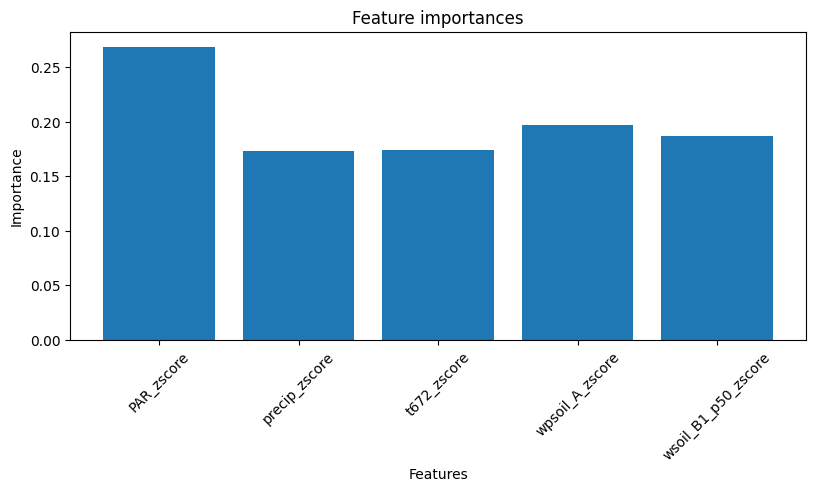

In [1173]:
# Plot feature importances
plt.figure(figsize=(9.5, 4))
plt.bar(X_train_class.columns, rfc.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.xticks(rotation=45)
plt.show()

## Decision tree

In [1238]:
# Create and fit the model
dtc = DecisionTreeClassifier(
    max_depth=max_depth, criterion="entropy", class_weight=class_weights
).fit(X_train_class, y_train_class)
# dtc = DecisionTreeClassifier(max_depth=5, criterion="entropy").fit(
# X_train_class, y_train_class
# )

# Predict with train set
y_pred_train = dtc.predict(X_train_class)

# Predict with test set
y_pred_test = dtc.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_dtc = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_dtc, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_dtc = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_dtc, 2))

Train accuracy: 0.67
Test accuracy: 0.7
-----
Train F1: 0.63
Test F1: 0.59


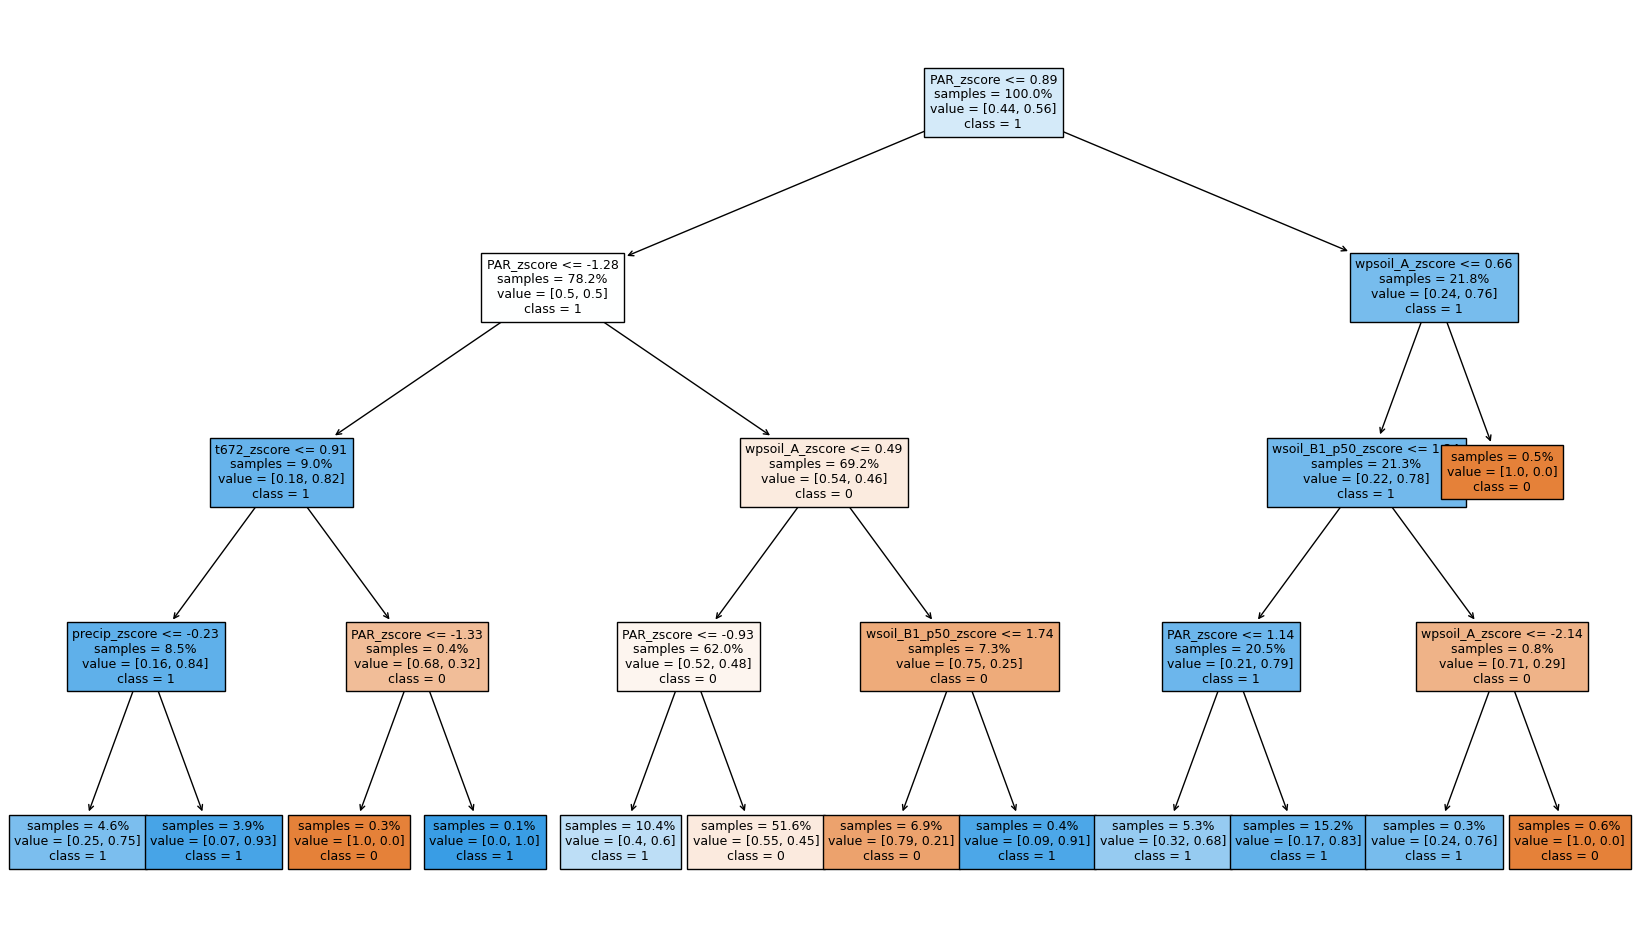

In [1218]:
from sklearn.tree import plot_tree

# Visualize the decision tree
plt.figure(figsize=(21, 12))
plot_tree(
    dtc,
    filled=True,
    precision=2,
    label="all",
    impurity=False,
    class_names=["0", "1"],
    fontsize=9,
    proportion=True,
    feature_names=X_train_class.columns.to_list(),
)
plt.show()

In [1219]:
dtc_text = tree.export_text(
    dtc, show_weights=False, feature_names=X_train_class.columns.to_list()
)
print(dtc_text)

|--- PAR_zscore <= 0.89
|   |--- PAR_zscore <= -1.28
|   |   |--- t672_zscore <= 0.91
|   |   |   |--- precip_zscore <= -0.23
|   |   |   |   |--- class: 1
|   |   |   |--- precip_zscore >  -0.23
|   |   |   |   |--- class: 1
|   |   |--- t672_zscore >  0.91
|   |   |   |--- PAR_zscore <= -1.33
|   |   |   |   |--- class: 0
|   |   |   |--- PAR_zscore >  -1.33
|   |   |   |   |--- class: 1
|   |--- PAR_zscore >  -1.28
|   |   |--- wpsoil_A_zscore <= 0.49
|   |   |   |--- PAR_zscore <= -0.93
|   |   |   |   |--- class: 1
|   |   |   |--- PAR_zscore >  -0.93
|   |   |   |   |--- class: 0
|   |   |--- wpsoil_A_zscore >  0.49
|   |   |   |--- wsoil_B1_p50_zscore <= 1.74
|   |   |   |   |--- class: 0
|   |   |   |--- wsoil_B1_p50_zscore >  1.74
|   |   |   |   |--- class: 1
|--- PAR_zscore >  0.89
|   |--- wpsoil_A_zscore <= 0.66
|   |   |--- wsoil_B1_p50_zscore <= 1.24
|   |   |   |--- PAR_zscore <= 1.14
|   |   |   |   |--- class: 1
|   |   |   |--- PAR_zscore >  1.14
|   |   |   |   |---

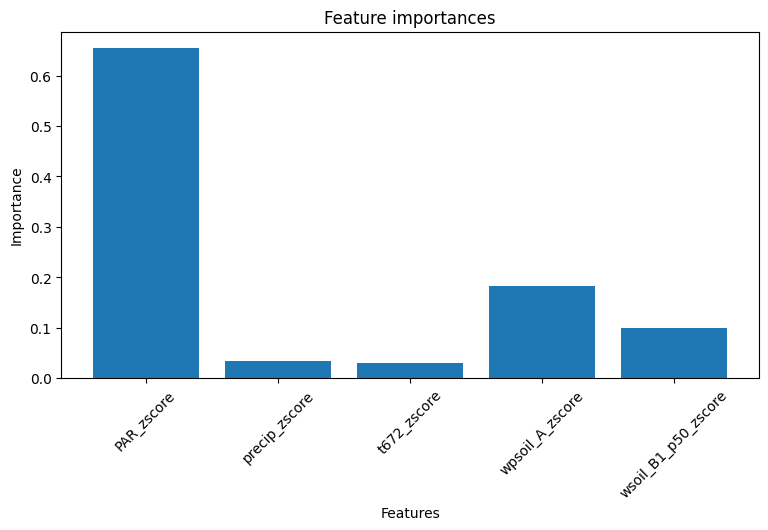

In [1220]:
# Plot feature importances
plt.figure(figsize=(9, 4.5))
plt.bar(X_train_class.columns, dtc.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.xticks(rotation=45)
plt.show()

## Logistic regression

In [1221]:
# Create and fit the model
# logr=LogisticRegression(max_iter=1000, tol=0.01).fit(X_train_class, y_train_class)
logr = LogisticRegression().fit(X_train_class, y_train_class)

# Predict with train set
y_pred_train = logr.predict(X_train_class)

# Predict with test set
y_pred_test = logr.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_logr = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_logr, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_logr = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_logr, 2))

Train accuracy: 0.59
Test accuracy: 0.51
-----
Train F1: 0.58
Test F1: 0.46


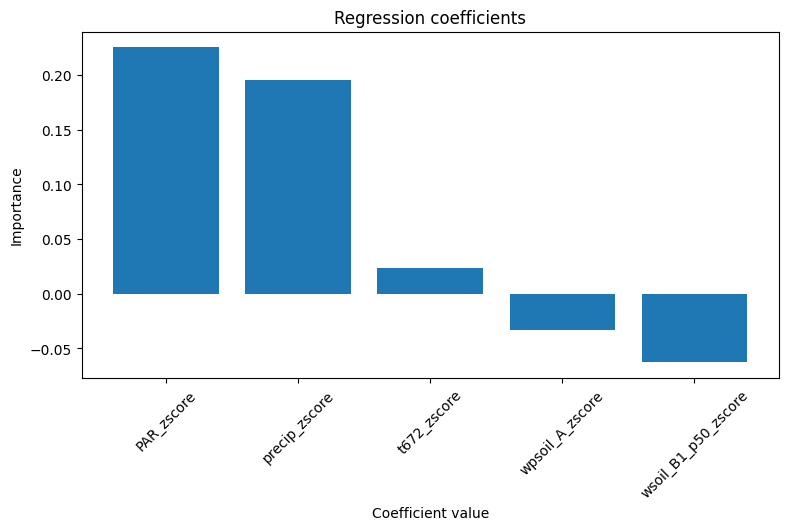

In [1222]:
# Plot regression coefficients
plt.figure(figsize=(9, 4.5))
plt.bar(X_train_class.columns, logr.coef_.flatten())
plt.xlabel("Coefficient value")
plt.ylabel("Importance")
plt.title("Regression coefficients")
plt.xticks(rotation=45)
plt.show()

In [1223]:
logr.coef_

array([[ 0.22534803,  0.19560755,  0.02386669, -0.03289085, -0.06270637]])

## LGBM

In [1224]:
# Create and fit the model
# lgbc=lightgbm.LGBMClassifier(verbose=-1).fit(X_train_class, y_train_class)
# lgbc=lightgbm.LGBMClassifier(num_leaves=25, max_depth=10, learning_rate=0.10, n_estimators=15,reg_alpha=0.1, verbose=-1).fit(X_train_class, y_train_class)
lgbc = lightgbm.LGBMClassifier(
    num_leaves=25,
    max_depth=5,
    learning_rate=0.08,
    n_estimators=15,
    reg_alpha=0.5,
    class_weight={0: 0.9, 1: 1.1},
    verbose=-1,
).fit(X_train_class, y_train_class)
# lgbc=lightgbm.LGBMClassifier(num_leaves=25, max_depth=5, learning_rate=0.08, n_estimators=15,reg_alpha=0.5, class_weight={0: 0, 1: 1}, verbose=-1).fit(X_train_class, y_train_class)

# Predict with train set
y_pred_train = lgbc.predict(X_train_class)

# Predict with test set
y_pred_test = lgbc.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_lgbc = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_lgbc, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_lgbc = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_lgbc, 2))

Train accuracy: 0.75
Test accuracy: 0.63
-----
Train F1: 0.77
Test F1: 0.54


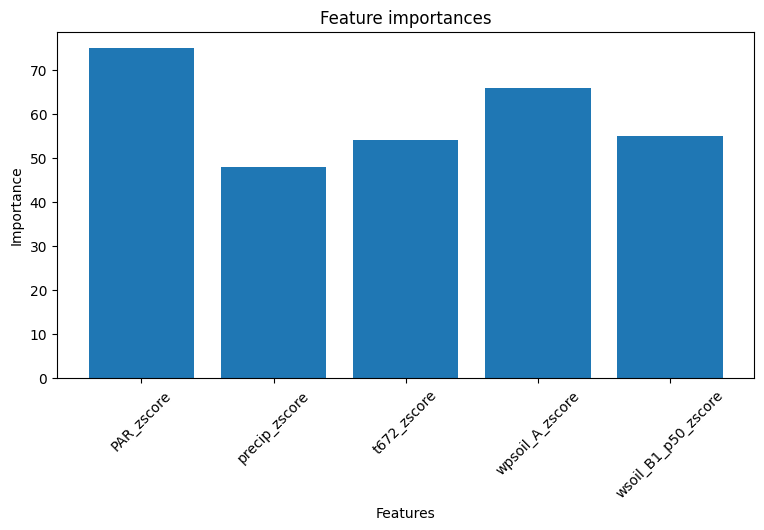

In [1225]:
# Plot feature importances
plt.figure(figsize=(9, 4.5))
plt.bar(X_train_class.columns, lgbc.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.xticks(rotation=45)
plt.show()

## Visualize the results

In [1226]:
# Select model results to visualize
model = "dtc"
assert model in ["rfc", "dtc", "logr", "lgbc"]

if model == "rfc":
    model = rfc
    test_accuracy = round(accuracy_rfc, 2)
    test_f1 = round(f1_rfc, 2)
    model_name = "Random Forest Classifier"
elif model == "dtc":
    model = dtc
    test_accuracy = round(accuracy_dtc, 2)
    test_f1 = round(f1_dtc, 2)
    model_name = "Decision Tree Classifier"
elif model == "logr":
    model = logr
    test_accuracy = round(accuracy_logr, 2)
    test_f1 = round(f1_logr, 2)
    model_name = "Logistic Regression"
elif model == "lgbc":
    model = lgbc
    test_accuracy = round(accuracy_lgbc, 2)
    test_f1 = round(f1_lgbc, 2)
    model_name = "LightGBM Classifier"

In [1227]:
def plot_year(year):
    # Filter data for the given year
    vis_year = vis[vis["Datetime"].dt.year == year]
    X_year = ddf2[ddf2["Datetime"].dt.year == year]

    # Reset the indexes
    vis_year.reset_index(drop=True, inplace=True)
    X_year.reset_index(drop=True, inplace=True)

    # Create the plot
    aux = [x + "_zscore" for x in TARGET_VARIABLES]
    ax = vis_year[aux].plot(kind="bar", stacked=True, figsize=(20, 8))

    # Plot z_score
    plt.plot(
        vis_year["z_score"], "k-", label="Combined z-score", linewidth=3, alpha=0.4
    )

    # Add markers for actual and predicted stress periods
    for i in range(len(X_year)):
        if X_year["stress"].iloc[i] == 1:
            plt.plot(i, combined_stress_threshold + 0.1, "bo", markersize=7)
        if model.predict(X_year[X_train_class.columns])[i] == 1:
            plt.plot(i, combined_stress_threshold - 0.1, "ro", markersize=7)

    # Add legend
    plt.plot([], [], "bo", markersize=7, label="Actual stress")
    plt.plot([], [], "ro", markersize=7, label="Predicted stress")
    plt.legend()

    # Add text box with information
    plt.text(
        5,
        vis_year[aux].where(vis_year[aux] < 0).sum(axis=1).min(),
        f"""Model: {model_name}\n\
Features: {X_train_class.columns.tolist()}\n\
Combined stress threshold: {combined_stress_threshold}\n\
Individual stress threshold: {individual_stress_threshold}\n\
Test accuracy (2010, 2018, 2021): {test_accuracy}\n\
Test F1-score (2010, 2018, 2021): {test_f1}\n\
Missing values: {'Imputed' if impute else 'Dropped'}\n\
Oversampling: {'SMOTE' if use_smote else 'None'}""",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    # Customize plot appearance
    plt.gcf().set_size_inches(16, 9)
    ticks = list(range(1, len(vis_year.Datetime.dt.dayofyear) + 1, 5))
    plt.xticks(
        ticks, labels=np.array(vis_year.Datetime.dt.dayofyear + 1)[np.array(ticks) - 1]
    )
    plt.title(f"Stress predictions {year}")
    plt.xlabel("Day of year")
    plt.ylabel("Z scores")
    plt.axhline(0, color="black", linewidth=0.5)  # Highlight x-axis
    plt.show()

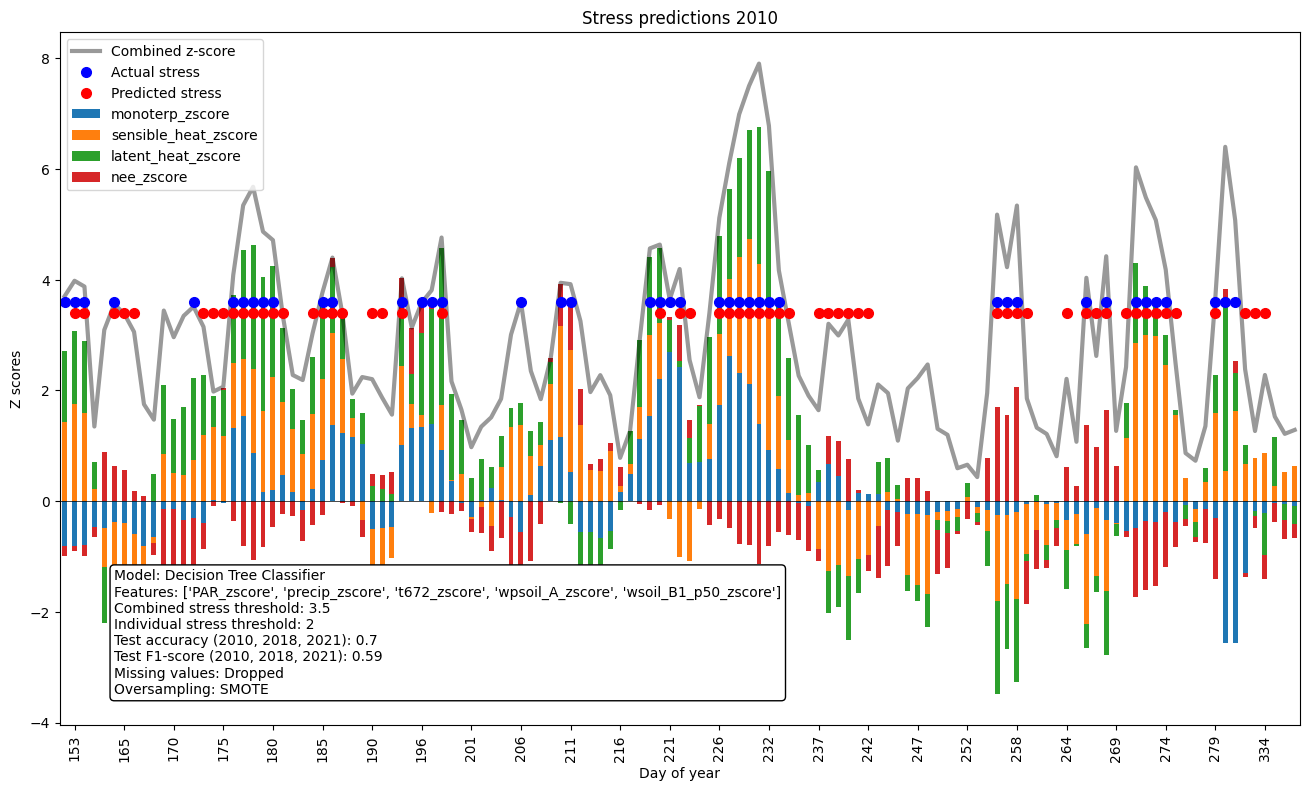

In [1228]:
plot_year(2010)

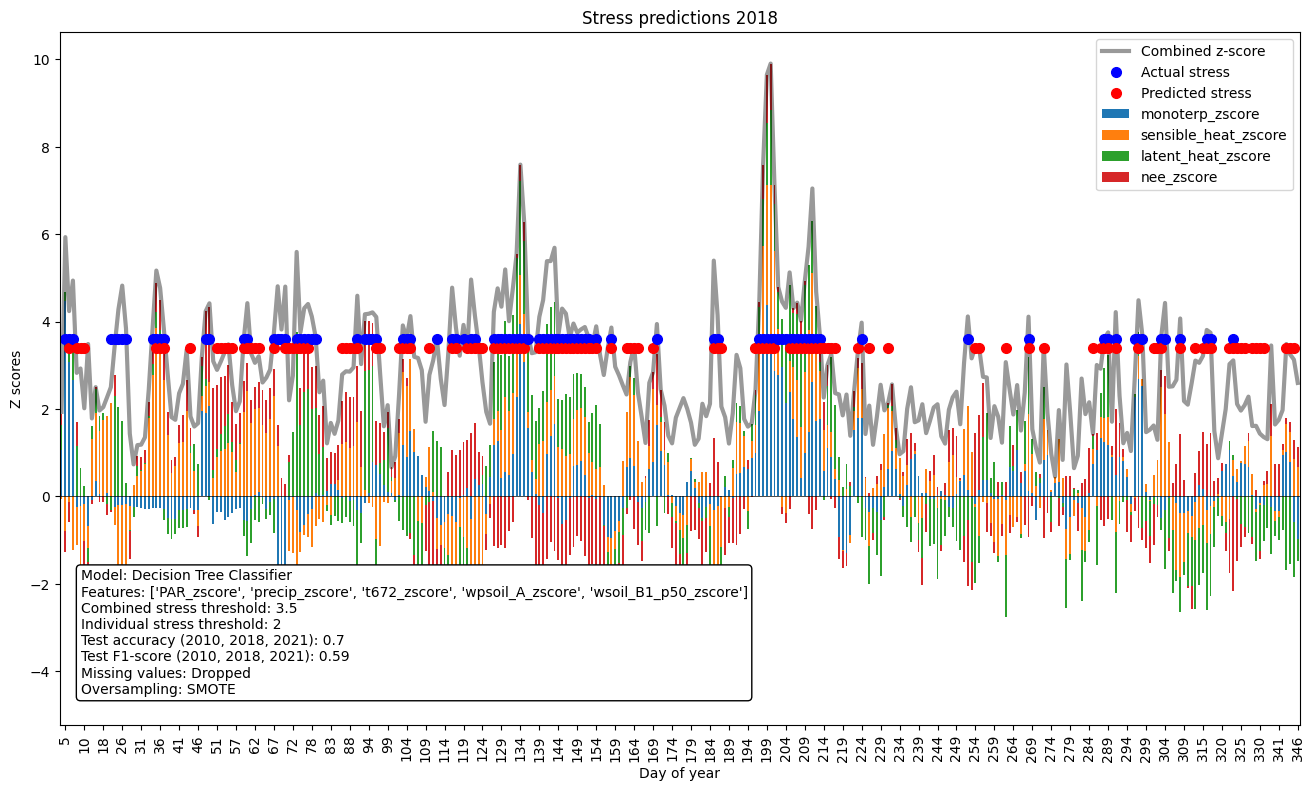

In [1229]:
plot_year(2018)

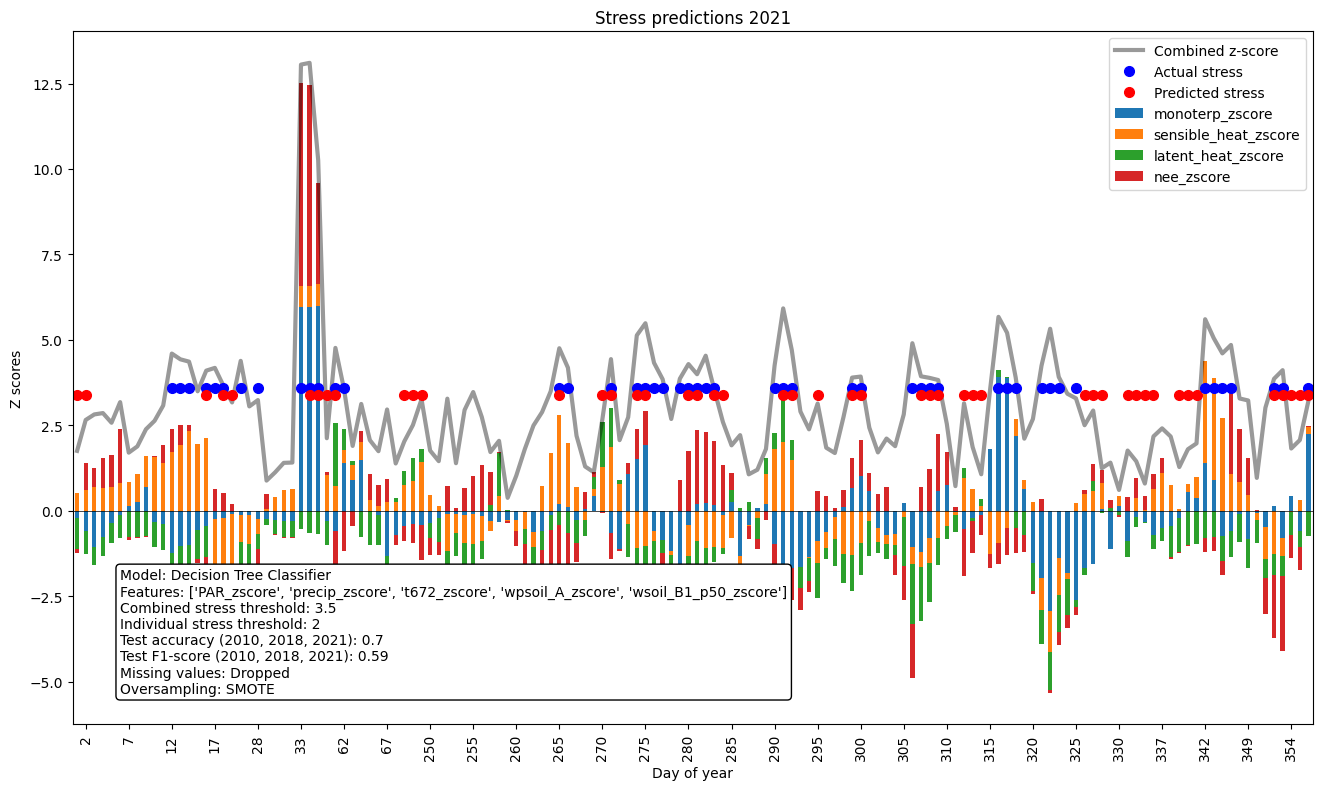

In [1230]:
plot_year(2021)